In [77]:
using PureSeq
using DataStructures
using Gadfly

In [116]:
function learn_feature(targetFile, controlFile, nbins; useReverseReads=false, maxCount=3200000000, keepDuplicates=false)
    targetReader = BamReader(targetFile, useReverseReads, ReferenceContigs_hg38)
    controlReader = BamReader(controlFile, useReverseReads, ReferenceContigs_hg38)
    P = 2*nbins + 1
    XtXcounts = zeros(Int64, P)
    Xty = zeros(Int64, P)
    targetValue = 0
    controlQueue = Deque{(Int64,Int64)}()
    tmp = Array(Int64, P)
    countTenth = int(maxCount/10)
    
    for i in 1:maxCount
        
        # remove old control positions that fell outside the sliding window
        while length(controlQueue) > 0 && front(controlQueue)[1] < i-nbins
            shift!(controlQueue)
        end
        
        # add new control positions in the sliding window
        if position(controlReader) != -1 && position(controlReader) <= i+nbins
            value = 0
            
            # get all the reads at this position
            pos = position(controlReader)
            while position(controlReader) == pos
                value += 1
                advance!(controlReader)
            end
            if !keepDuplicates
                value = 1
            end
            push!(controlQueue, (pos, value))
            
            
            # update XtXcount
            for (pos1,value1) in controlQueue
                XtXcounts[pos-pos1+1] += value*value1
            end
        end
        
        # get the current target count
        targetValue = 0
        while position(targetReader) == i
            targetValue += 1
            advance!(targetReader)
        end
        if !keepDuplicates && targetValue != 0
            targetValue = 1
        end
        
        # update Xty
        if targetValue != 0
            for (pos1,value1) in controlQueue
                Xty[pos1 - i + nbins + 1] += targetValue*value1
            end
        end
        
        if i % countTenth == 0
            println(i)
        end
    end
    
    close(targetReader)
    close(controlReader)
    
    XtXcounts, Xty
end

learn_feature (generic function with 1 method)

In [126]:
root = "/scratch2/slund1/ENCSR000BQS_notebook"
@time XtXcounts_2k, Xty_2k = learn_feature("$root/ENCFF000NYK.bam", "$root/ENCFF000ODO.bam", 2000, useReverseReads=false);

320000000
640000000
960000000
1280000000
1600000000
1920000000
2240000000
2560000000
2880000000
3200000000
elapsed time: 313.703882812 seconds (22766043272 bytes allocated, 15.43% gc time)


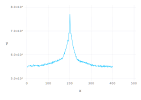

In [123]:
Xty_200 = Xty2[20001-200:20001+200]
XtXcounts_200 = Xty2[20001-200:20001+200]
plot(x=1:length(Xty_200), y=Xty_200, Geom.line)

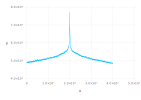

In [124]:
Xty_2k = Xty2[20001-2000:20001+2000]
XtXcounts_2k = XtXcounts2[1:4001]
plot(x=1:length(Xty_2k), y=Xty_2k, Geom.line)

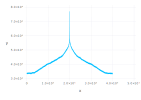

In [118]:
#XtXcounts_f, Xty_f = learn_feature("$root/ENCFF000NYK.bam", "$root/ENCFF000ODO.bam", 20000, useReverseReads=false)
plot(x=1:length(Xty2), y=Xty2, Geom.line)

320000000
640000000
960000000
1280000000
1600000000
1920000000
2240000000
2560000000
2880000000
3200000000


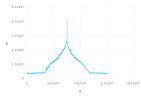

In [65]:
XtXcounts_f, Xty_f = learn_feature("$root/ENCFF000NYK.bam", "$root/ENCFF000ODO.bam", 30000, useReverseReads=false)
plot(x=1:length(Xty_f), y=Xty_f, Geom.line)

In [101]:
XtXcounts_f, Xty_f = learn_feature("$root/ENCFF000NYK.bam", "$root/ENCFF000ODO.bam", 30000,  maxCount=3200000000, useReverseReads=false)
#plot(x=1:length(Xty_f), y=Xty_f, Geom.line)
1;

320000000
640000000
960000000
1280000000
1600000000
1920000000
2240000000
2560000000
2880000000
3200000000


In [14]:
function build_XtX(XtXcounts)
    P = length(XtXcounts)
    XtX = zeros(Float64, P, P)
    for i in 1:P
        for j in i:P
            XtX[j,i] = XtX[i,j] = XtXcounts[j-i+1]
        end
    end
    XtX
end

build_XtX (generic function with 1 method)

In [15]:
function fused_ridge(XtX, Xty, lambda)
    P = length(Xty)
    D = eye(P)
    for i in 1:P-1
        D[i,i+1] = -1
    end
    D[P,P] /= lambda
    invD = inv(D)
    #println(invD)
    invD*inv(invD'XtX*invD .+ lambda*eye(P))*invD'Xty
end

fused_ridge (generic function with 1 method)

In [59]:
function bin_tails(counts, binSize, outerFactor)
    
    numBins = int(outerFactor * length(counts) / binSize)
    println("numBins $numBins")
    
    width = (length(counts)-1)/2
    out = Float64[]
    outPos = Int64[]
    pos = 1
    for i in 1:numBins
        push!(outPos, pos)
        push!(out, sum(counts[pos:pos+binSize-1])/binSize)
        pos += binSize
    end
    for i in 1:length(counts)-2*numBins*binSize
        push!(outPos, pos)
        push!(out, counts[pos])
        pos += 1
    end
    for i in 1:numBins
        push!(outPos, pos)
        push!(out, sum(counts[pos:pos+binSize-1])/binSize)
        pos += binSize
    end
    outPos,out
end

bin_tails (generic function with 3 methods)

In [111]:
function bin_values(arr, step)
    out = Float64[]
    for i = 1:step:length(arr)
        push!(out, mean(arr[i:min(i+step-1,length(arr))]))
    end
    out
end

bin_values (generic function with 1 method)

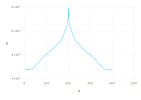

In [119]:
XtXcounts2b = bin_values(XtXcounts2, 100)
XtX2b = build_XtX(XtXcounts2b)
Xty2b = bin_values(Xty2, 100)
plot(x=1:length(Xty2b), y=Xty2b, Geom.line)

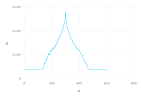

In [102]:
XtXcounts_fb = bin_values(XtXcounts_f, 100)
XtX_fb = build_XtX(XtXcounts_fb)
Xty_fb = bin_values(Xty_f, 100)
plot(x=1:length(Xty_fb), y=Xty_fb, Geom.line)

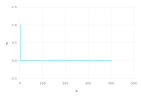

In [125]:
XtX_200 = build_XtX(XtXcounts_200)
betas = fused_ridge(XtX_200, Xty_200, 10.0)
plot(x=1:length(betas), y=betas, Geom.line)

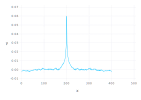

In [120]:
betas = fused_ridge(XtX2b, Xty2b, 10.0)
plot(x=1:length(betas), y=betas, Geom.line)

numBins 288
2977


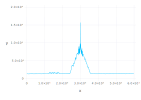

In [78]:
binnedPos,Xty_fb = bin_tails(Xty_f, 100, 0.48)
println(length(Xty_fb))
plot(x=binnedPos, y=Xty_fb, Geom.line)

In [ ]:
binnedPos,Xty_fb = bin_tails(Xty_f, 3, 0.3)

In [63]:
XtX_f = build_XtX(XtXcounts_f)

401x401 Array{Int64,2}:
 15573061   1411941   1412622   1331786  …    687359    698003    685300
  1411941  15573061   1411941   1412622       692623    687359    698003
  1412622   1411941  15573061   1411941       696639    692623    687359
  1331786   1412622   1411941  15573061       698821    696639    692623
  1234108   1331786   1412622   1411941       693324    698821    696639
  1264414   1234108   1331786   1412622  …    695670    693324    698821
  1187605   1264414   1234108   1331786       691060    695670    693324
  1208231   1187605   1264414   1234108       682201    691060    695670
  1126008   1208231   1187605   1264414       698233    682201    691060
  1159199   1126008   1208231   1187605       690960    698233    682201
  1127887   1159199   1126008   1208231  …    684701    690960    698233
  1111715   1127887   1159199   1126008       704584    684701    690960
  1134155   1111715   1127887   1159199       690188    704584    684701
        ⋮                  

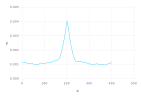

In [108]:
XtX = build_XtX(XtXcounts2)
betas = fused_ridge(XtX, Xty2, 10000000.0)
plot(x=1:length(betas), y=betas, Geom.line)

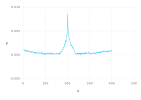

In [28]:
XtX = build_XtX(XtXcounts2)
betas = fused_ridge(XtX, Xty2, 100.0)
plot(x=1:length(betas), y=betas, Geom.line)

In [119]:
import PureSeq.advance!

In [23]:
transpose(ones(10,10)) .* eye(10)

10x10 Array{Float64,2}:
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0

In [ ]:
type DenseBlocks
    readers::Array{Any}
    blockSize::Int64
end

In [134]:
reload("PureSeq")
using PureSeq
FeatureMap = PureSeq.FeatureMap

FeatureMap (constructor with 3 methods)

In [135]:
type DenseBlockIterator
    readers::Array{Any}
    blockSize::Int64
    blockWidth::Int64
    block::Array{Float64,2}
    offset::Int64
    done::Bool
    constantColumn::Bool
end
function denseblocks(readers, blockSize::Int64; constantColumn=false)
    blockWidth = constantColumn ? length(readers) + 1 : length(readers)
    block = ones(Float64, blockSize, blockWidth)
    if constantColumn
        block[:,end] = 1.0
    end
    DenseBlockIterator(readers, blockSize, blockWidth, block, 0, false, constantColumn)
end
Base.start(it::DenseBlockIterator) = 0
Base.done(it::DenseBlockIterator, nil) = it.done
function Base.next(it::DenseBlockIterator, nil)
    it.done = true
    
    if it.constantColumn
        it.block[:,1:end-1] = 0.0
    else
        it.block[:,:] = 0.0
    end

    # Fill in the block
    for i in 1:length(it.readers)
        reader = it.readers[i]

        while !eof(reader) && position(reader) <= it.offset + it.blockSize
            it.block[reader.position - it.offset, i] += value(reader)
            advance!(reader)
            it.done = false
        end
    end

    # See if we are really done or just found a blank block
    if it.done
        for i in 1:length(it.readers)
            it.done = it.done && eof(it.readers[i])
        end
    end
    
    # update the offset
    it.offset += it.blockSize

    it.block,nothing
end

next (generic function with 112 methods)

In [136]:
i = 0
controlIds = ["ENCFF000ODO", "ENCFF000ODV"]
readers = map(x->FeatureMap(BamReader("$root/$x.bam", false, ReferenceContigs_hg38), betas), controlIds)
#fm = FeatureMap(reader, betas)
for block in denseblocks(readers, 1000, constantColumn=true)
    i += 1
    #show(block)
    if i > 12
        break
    end
    println("$i ", sum(block))
end

LoadError: `FeatureMap` has no method matching FeatureMap(::BamReader, ::Array{Float64,1})
while loading In[136], in expression starting on line 3

In [67]:
function train_from_features(target, features; maxCount=3200000000, blockSize=100000)
    P = length(features)+1
    featureBlock = zeros(Float64, blockSize, P)
    featureBlock[:,end] = 1.0 # constant feature
    targetBlock = zeros(Float64, blockSize)
    
    offset = 0
    for i in 1:maxCount
        
        if i-offset > blockSize
            done = true
            offset += blockSize
            featureBlock[:,1:end-1] = 0.0
            targetBlock[:] = 0.0

            # Fill in the target block
            while target.position != -1 && target.position <= offset + blockSize
                targetBlock[target.position - offset] += 1.0
                advance!(target)
                done = false
            end

            # Fill in the feature block
            for i in 1:length(features)
                fm = features[i]

                while fm.position != -1 && fm.position <= offset + blockSize
                    featureBlock[fm.position - fb.offset, i] += fm.value
                    advance!(fm)
                    done = false
                end
            end

            # See if we are really done or just found a blank block
            if done
                done = done && target.position == -1
                for i in 1:length(features)
                    fb.done = fb.done && fb.features[i].position == -1
                end
            end

            fb.offset += fb.blockSize
        end
        
        # remove old control positions that fell outside the sliding window
        while length(controlQueue) > 0 && front(controlQueue)[1] < i-nbins
            shift!(controlQueue)
        end
        
        # add new control positions in the sliding window
        if controlReader.position != -1 && controlReader.position <= i+nbins
            value = 0
            
            # get all the reads at this position
            pos = controlReader.position
            while controlReader.position == pos
                value += 1
                advance!(controlReader)
            end
            push!(controlQueue, (pos, value))
            
            # update XtXcount
            predictValue = 
            for (pos1,value1) in controlQueue
                XtXcounts[pos-pos1+1] += value*value1
            end
        end
        
        # get the current target count
        targetValue = 0
        while targetReader.position == i
            targetValue += 1
            advance!(targetReader)
        end
        
        # update Xty
        if targetValue != 0
            for (pos1,value1) in controlQueue
                Xty[pos1 - i + nbins + 1] += targetValue*value1
            end
        end
        
        if i % countTenth == 0
            println(i)
        end
    end
    
    close(targetReader)
    close(controlReader)
    
    XtXcounts, Xty
end

learn_feature (generic function with 1 method)

In [186]:
type FeatureBlocks
    targetBlock::Array{Float64,1}
    featureBlock::Array{Float64,2}
    target::BamReader
    features::Array{FeatureMap}
    done::Bool
    offset::Int64
    blockSize::Int64
    blockWidth::Int64
end

function FeatureBlocks(target::BamReader, features::Array{FeatureMap}, blockSize::Int64)
    blockWidth = length(features) + 1
    fb = FeatureBlocks(zeros(blockSize, blockWidth), target, features, false, 0, blockSize, blockWidth)
    
    # the last column of the block is the constant feature
    fb.block[:,end] = 1.0
    
    # fill in the block
    advance!(fb)
    
    fb
end

function advance!(fb::FeatureBlocks)
    fb.block[:,1:end-1] = 0.0
    fb.done = true
    
    # Fill in the target column
    while fb.targetReader.position != -1 && fb.targetReader.position <= fb.offset + fb.blockSize
        fb.blocks[fb.targetReader.position - fb.offset, 1, b] += 1.0
        advance!(fb.targetReader)
        fb.done = false
    end
    
    # Fill in the control columns
    for i in 1:length(fb.controlReaders)
        reader = fb.controlReaders[i]
        
        while reader.position != -1 && reader.position <= fb.offset + fb.blockSize
            fb.blocks[reader.position - fb.offset, 1+i, b] += 1.0
            advance!(reader)
            fb.done = false
        end
    end
    
    # See if we are really done or just found a blank block
    if fb.done
        fb.done = fb.done && fb.targetReader.position == -1
        for i in 1:length(fb.controlReaders)
            fb.done = fb.done && fb.controlReaders[i].position == -1
        end
    end

    fb.offset += fb.blockSize
end

In [186]:
type FeatureBlocks
    blocks::Array{Float32,3}
    targetReader::BamReader
    controlReaders::Array{BamReader}
    done::Bool
    offset::Int64
    blockSize::Int64
    blockWidth::Int64
    pcrevInd::Int64
    currInd::Int64
    nextInd::Int64
end

In [233]:
function FeatureBlocks(targetReader::BamReader, controlReaders::Array{BamReader}, blockSize::Int64)
    blockWidth = length(controlReaders) + 2
    fb = FeatureBlocks(zeros(blockSize, blockWidth, 3), targetReader, controlReaders, false, 0, blockSize, blockWidth, 1, 2, 3)
    
    # the last column of each block is the constant feature
    fb.blocks[:,end,:] = 1.0
    
    # fill in the current and next blocks
    fillBlock!(fb, 2)
    fillBlock!(fb, 3)
    
    fb
end

function fillBlock!(fb::FeatureBlocks, b::Int64)
    block = fb.blocks[b]
    fb.blocks[:,1:end-1,b] = 0
    fb.done = true
    
    # Fill in the target column
    while fb.targetReader.position != -1 && fb.targetReader.position <= fb.offset + fb.blockSize
        fb.blocks[fb.targetReader.position - fb.offset, 1, b] += 1.0
        advance!(fb.targetReader)
        fb.done = false
    end
    
    # Fill in the control columns
    for i in 1:length(fb.controlReaders)
        reader = fb.controlReaders[i]
        
        while reader.position != -1 && reader.position <= fb.offset + fb.blockSize
            fb.blocks[reader.position - fb.offset, 1+i, b] += 1.0
            advance!(reader)
            fb.done = false
        end
    end
    
    # See if we are really done or just found a blank block
    if fb.done
        fb.done = fb.done && fb.targetReader.position == -1
        for i in 1:length(fb.controlReaders)
            fb.done = fb.done && fb.controlReaders[i].position == -1
        end
    end

    fb.offset += fb.blockSize
end

function advance!(fb::FeatureBlocks)

    # advance the block cache indexes
    fb.prevInd = (fb.prevInd%3)+1;
    fb.currInd = (fb.currInd%3)+1;
    fb.nextInd = (fb.nextInd%3)+1;

    # fill the next block with new values
    fillBlock!(fb, fb.nextInd);
    #computeCurrBlockFeatures();
end

function block(fb)
    fb.blocks[:,:,fb.currInd]
end

block (generic function with 1 method)

In [247]:
function test2()
    r1 = BamReader("/scratch2/slund1/ENCSR000BQS_notebook/ENCFF000XRH.bam", false, contigsHg38)
    r2 = BamReader("/scratch2/slund1/ENCSR000BQS_notebook/ENCFF000XRI.bam", false, contigsHg38)
    fb = FeatureBlocks(r1, [r2], 1000000)
    i = 0
    P = size(block(fb))[2]-1
    XtX = zeros(P,P)
    while !fb.done
        i += 1
        X = block(fb)[:,2:end]
        XtX .+= X'X
        if i % 50 == 0
            println(i)
        end
        advance!(fb)
    end
    close(r1)
    close(r2)
end

test2 (generic function with 1 method)

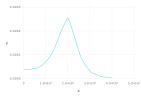

In [584]:
function fused_ridge(XtX, Xty, lambda)
    P = length(Xty)
    D = eye(P)
    for i in 1:P-1
        D[i,i+1] = -1
    end
    D[P,P] /= lambda
    invD = inv(D)
    #println(invD)
    invD*inv(invD'XtX*invD .+ lambda*eye(P))*invD'Xty
end
XtX = build_XtX(XtXcounts)
betas = fused_ridge(XtX, Xty, 10000000000000.0)
plot(x=1:length(betas), y=betas, Geom.line)

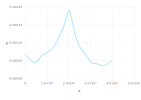

In [587]:
function fused_ridge(XtX, Xty, lambda)
    P = length(Xty)
    D = eye(P)
    for i in 1:P-1
        D[i,i+1] = -1
    end
    D[P,P] /= lambda
    invD = inv(D)
    #println(invD)
    invD*inv(invD'XtX*invD .+ lambda*eye(P))*invD'Xty
end
XtX = build_XtX(XtXcounts)
betas = fused_ridge(XtX, Xty, 10000000000000.0)
plot(x=1:length(betas), y=betas, Geom.line)

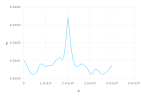

In [588]:
function fused_ridge(XtX, Xty, lambda)
    P = length(Xty)
    D = eye(P)
    for i in 1:P-1
        D[i,i+1] = -1
    end
    D[P,P] /= lambda
    invD = inv(D)
    #println(invD)
    invD*inv(invD'XtX*invD .+ lambda*eye(P))*invD'Xty
end
XtX = build_XtX(XtXcounts)
betas = fused_ridge(XtX, Xty, 1000000000000.0)
plot(x=1:length(betas), y=betas, Geom.line)

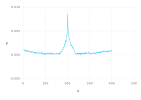

In [573]:
betas = inv(XtX)*Xty
plot(x=1:length(betas), y=betas, Geom.line)